## AI Bot Trader - Robô Investidor Para Recomendação de Compras de Venda de Ações

Nesse projeto iremos construir uma AI Bot Trader para recomendação de compra e Vendas de ações. Iremos extrair dados da Bovesta, tais como:

* Cotações diárias históricas;
* Dados intraday;
* Informações financeiras;

Nosso modelo irá analisar dados financeiros históricos e recomendar a quantidade ação que devemos comprar e vender ppara uma melhor rentabilidade. Iremos trabalhar tanto com a linguagem Python como a Linguagem R.

![projeto](imagens/projeto.png)

**Etapas do Projeto:**

* Parte 1 - Extração dos Dados;
* Parte 2 - Análise Financeira das ações;
* Parte 3 - Construção do Modelo e Otimização Bayesiana;
* Parte 4 - Execução do AI Bot Trader
* Parte 5 - Conclusão 

## 1. Extração de Dados

Primeiramente iremos carregar algumas bibliotecas em python para importar os dados históricos diários das ações da Petrobrás (PETR4.SA), Iatú (ITSA4) e a Ambev (ABEV3), de 01 de janeiro de 2018 até a data de hoje. 

In [100]:
# Import Package
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import csv
import time
import random
import types
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
from pprint import pprint
from datetime import datetime
sns.set()

# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [21]:
# 
TickerA='PETR4.SA'
TickerB='ITUB3.SA'
TickerC='ABEV3.SA'

prices=pd.DataFrame()
tickers = [TickerA, TickerB, TickerC]
for t in tickers:
    prices[t]=wb.DataReader(t, data_source='yahoo', start='2018-1-1')['Adj Close']

Utilizando o Matplotlib, plotei no gráfico da figura abaixo os preços de cada um dos três ativos. O eixo horizontal representa o tempo, enquanto o eixo vertical representa o preço do ativo normalizado

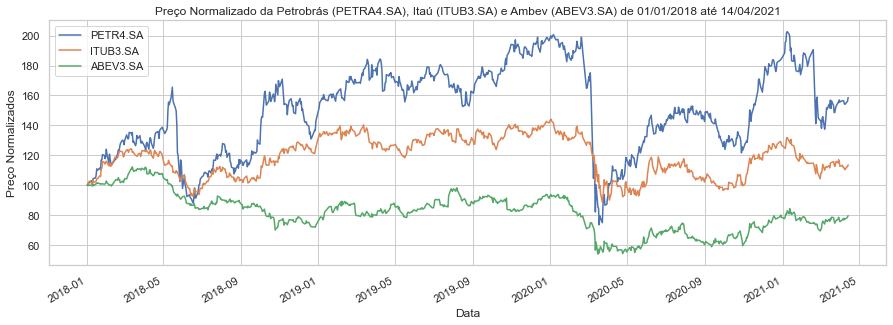

In [26]:
(prices/prices.iloc[0]*100).plot(figsize=(15,5))
plt.ylabel('Preço Normalizados')
plt.xlabel('Data')
plt.title("Preço Normalizado da Petrobrás (PETRA4.SA), Itaú (ITUB3.SA) e Ambev (ABEV3.SA) de 01/01/2018 até 14/04/2021")
plt.show()

## 2. Análise de Dados

### 2.1. Retorno Diário

Para calcular quanto um ativo retornou em um dia, basta tomar a variação do preço no dia anterior para o preço no dia atual (P1 - P0), e dividir pelo valor do ativo no dia anterior (P0):

![png](imagens/ret_d.png)


Outra maneira, que iremos utilizar é utilizando o logarítmo, do pacode numpy.

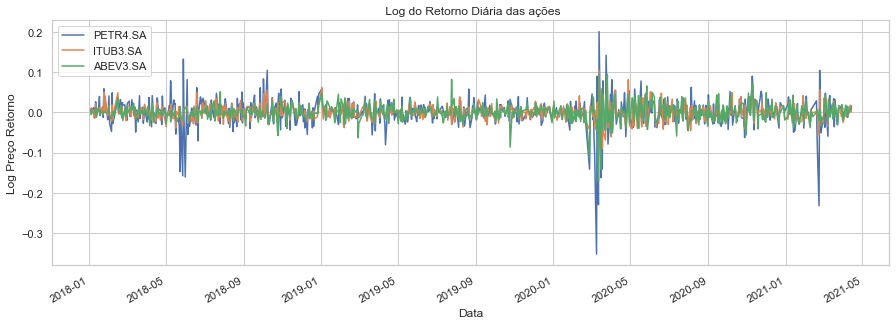

In [30]:
log_returns=np.log(prices/prices.shift(1))

log_returns.plot(figsize = (15,5))
plt.ylabel('Log Preço Retorno')
plt.xlabel('Data')
plt.title(" Log do Retorno Diária das ações")
plt.show()

### 2.2.  Retorno diário médio x Retornos anuais médios

Agora iremos saber quanto cada ativo variou em média por dia desde 2018 até a data de hoje. Iremos calcular o valor médio (diário) dos dados. 

In [31]:
log_returns.mean()

PETR4.SA    0.000572
ITUB3.SA    0.000158
ABEV3.SA   -0.000282
dtype: float64

Ao observar o resultado podemos falar que as ações da Petrobrás, comparado com o IOtaú e a Ambev teve o maior rendimento diário médio, de aproximadamente 0.05% entre 2018 a 2021. 
Para sabermos o retorno médio por ano, basta multiplicarmos em por 250, média de dias ao ano que o mercado se encontra e,m operação.
Ao observar abaixo temos o rendimento anual médio das ações da Petrobrás, Itaú e Ambev de 14,30 % a.a, 3,95 % a.a e -7,05% a.a respectivamente. 

In [32]:
log_returns.mean()*250

PETR4.SA    0.143049
ITUB3.SA    0.039486
ABEV3.SA   -0.070501
dtype: float64

Abaixo iremos analisar o retorno diário da Petrobrás, através de um histograma.

c:\users\rodolfo\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, ' Histograma Log do Retorno Diária da Petrobrás')

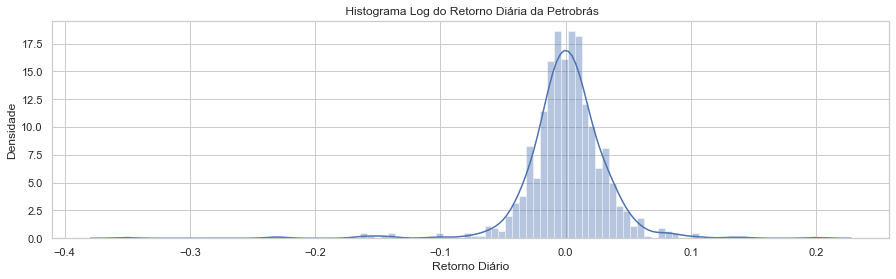

In [54]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
sns.distplot(log_returns['PETR4.SA'], bins=100, ax=ax1)
plt.ylabel('Densidade')
plt.xlabel('Log do Retorno Diária das ações')
plt.xlabel('Retorno Diário')
plt.title(" Histograma Log do Retorno Diária da Petrobrás")

### 2.3 Computando o risco (desvio Padrão)


Ao realizar uma aplicação financeira, o investidor geralmente procura bons retornos, mas o risco de perder dinheiro muitas vezes pode levá-lo a tomar uma atitude mais conservadora, e consequentemente obter um retorno menor. Geralmente maiores retornos têm uma maior probabilidade de virem acompanhados de riscos maiores. Se o risco é importante, então como poderíamos estimar o risco de um determinado ativo

Conceitos de estatística como variância e desvio padrão podem nos ajudar quando desejamos quantificar o risco de um ativo. É esperado que uma ação volátil possa desviar muito do seu valor médio, para mais ou para menos. Essa medida do quanto a variável desvia do seu valor médio é a variância, dada pela fórmula:

![std](imagens/std_d.png)

Na equação acima, **n** representa o número de dados, e o termo negativo no numerador é o valor médio de **x**. A raiz quadrada da variância (ou seja, **s**) é chamada de **desvio padrão**. Em finanças, o desvio padrão representa o risco (ou a volatilidade) do ativo.

Abaixo temos a volatilidade dos retornos diários para as ações da Petrobrás, Itaú e Ambev

In [59]:
log_returns.std()

PETR4.SA    0.034704
ITUB3.SA    0.019939
ABEV3.SA    0.021151
dtype: float64

### 2.4. Correlação entre retorno diários

Podemos utilizar o conceito de correlação para analisar o quanto a variação de um ativo pode ou não interferir na variação do outro. A correlação entre duas variáveis x e y (corr(x,y)) se apresenta como um número real entre -1 e 1, onde: 0 < corr(x,y) < 1 (correlação positiva) significa que o aumento de x influencia no aumento de y; -1 < corr(x,y) < 0 (correlação negativa) significa que o aumento de x influencia na redução de y; e corr(x,y) = 0 significa que as variáveis x e y são independentes. Dessa forma, duas variáveis fortemente correlacionadas terão o valor absoluto da correlação muito próximo de 1 (podendo ser positivamente ou negativamente correlacionadas).

Podemos interpretar a tabela abaixo como uma matriz em que cada elemento é a correlação da linha e da coluna associadas. Dessa forma, naturalmente que a variação do preço da Petrobrás, por exemplo, é fortemente correlacionada com o Itaú, com um valor de 0.5953, e também uma correção positiva com a Ambev, ou seja, quando uma ação tende a subir ou cair, consequentemente as demais outras tende a seguir a mesma tendência.

In [62]:
log_returns.corr()

,PETR4.SA,ITUB3.SA,ABEV3.SA
PETR4.SA,1.000000,0.595300,0.445718
ITUB3.SA,0.595300,1.000000,0.557336
ABEV3.SA,0.445718,0.557336,1.000000


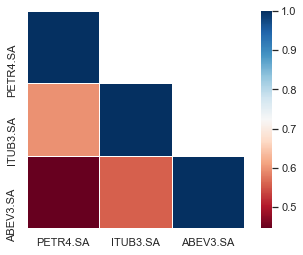

In [58]:
def plot_corr(corr):
    #Cortaremos a metade de cima do gráfico
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True
    
    sns.heatmap(corr, mask = mask, cmap = 'RdBu', square = True, linewidths = 0.50)
    
# Calcula a correlação
corr = log_returns.corr()
plot_corr(corr)

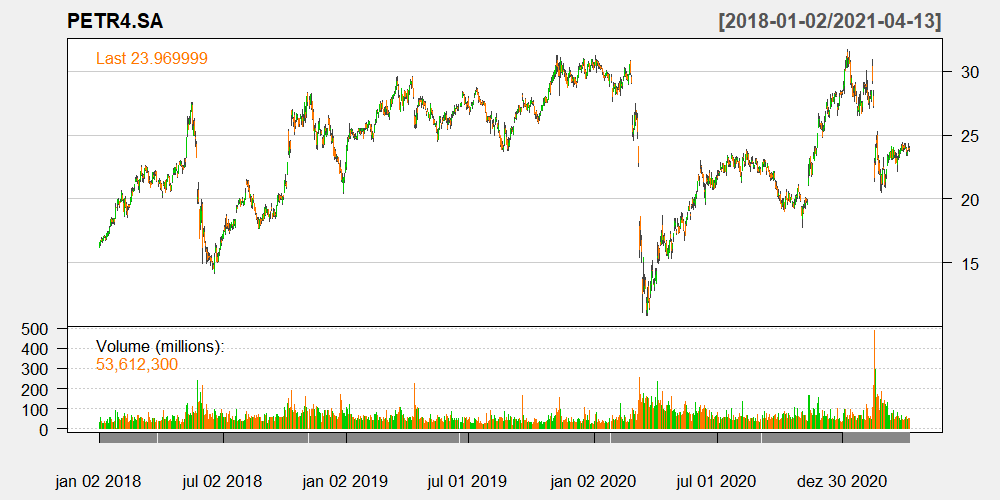

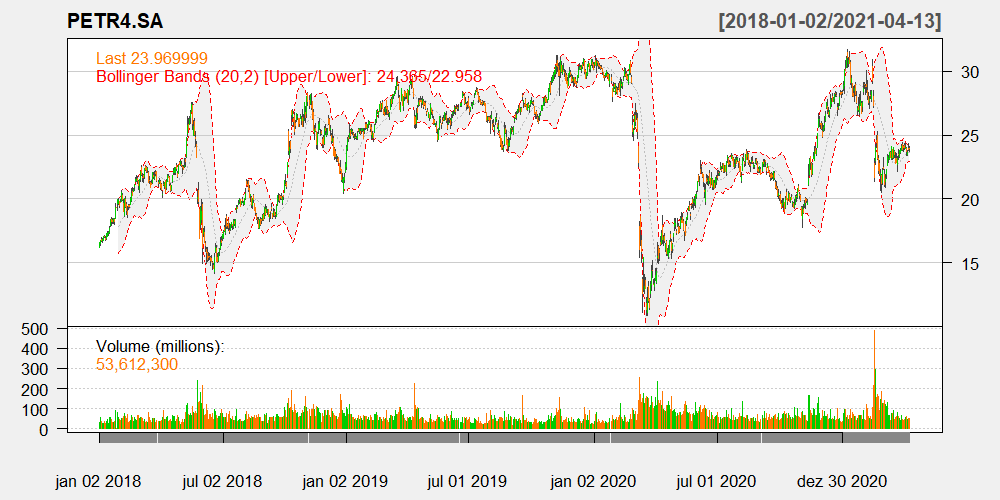

In [96]:
%%R -i df -w 10 -h 5 --units in -r 100

library("quantmod")

Ações <- c('PETR4.SA')
Data_Inicio = as.Date("2018-01-01")
df <- getSymbols(Ações, src = "yahoo", from = Data_Inicio)

chartSeries(PETR4.SA, theme='white')
addBBands()



## 3. Construção do Modelo e Otimização Bayesiana

Analisando as 03 ações, iremos agora construir o modelo apenas para a ação de maior rentabilidade, ou seja a Petrobrás. Iremos coletar novos dados, somente da Petrobrás, para construirmos o modelo.

In [101]:
# escolher a ação desejada
acao = 'PETR4.SA'

# importar dados para o DataFrame
df = web.DataReader(acao, data_source='yahoo', start='01-01-2018')

# ver as 5 primeiras entradas
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,16.549999,16.190001,16.190001,16.549999,33461800.0,15.353476
2018-01-03,16.719999,16.370001,16.490000,16.700001,55940900.0,15.492632
2018-01-04,16.959999,16.620001,16.780001,16.730000,37064900.0,15.520462
2018-01-05,16.860001,16.570000,16.700001,16.830000,26958200.0,15.613233
2018-01-08,17.030001,16.709999,16.740000,17.030001,28400000.0,15.798772


In [105]:
# Shape
df.shape

(807, 6)

In [118]:
# Dados de Fechamento
close = df.Close.values.tolist()

In [119]:
# Outros parâmetros para a versão base do modelo
window_size = 30
skip = 5
l = len(close) - 1

In [120]:
# Classe para a estratégia de treinamento
# Usamos Deep Evolution Strategy do OpenAI
class PoliticaTrader:

    # Inputs
    inputs = None

    # Construtor
    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        
        # Inicializa os atributos da classe
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    # Obtém o peso a partir da população
    def get_weights_population(self, weights, population):
        
        # Lista para os pesos
        weights_population = []
        
        # Loop pela população
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        
        return weights_population

    # Obtém os pesos
    def get_weights(self):
        return self.weights

    # Treinamento
    def treinamento(self, epoch = 100, print_every = 1):
        
        # Time
        lasttime = time.time()
        
        # Loop pelas épocas
        for i in range(epoch):
            
            # Lista para a população
            population = []
            
            # Recompensas
            rewards = np.zeros(self.population_size)
            
            # Loop pelo population_size
            for k in range(self.population_size):
                
                x = []
                
                # Loop
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                    
                population.append(x)
            
            # Loop
            for k in range(self.population_size):
                
                weights_population = self.get_weights_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            
            # Recompensas
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            
            # Loop
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                
                # Pesos da rede neural 
                self.weights[index] = (w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T)
            
            if (i + 1) % print_every == 0:
                print('Iteração %d. Recompensa: %f' % (i + 1, self.reward_function(self.weights)))
        
        print('Tempo Total de Treinamento:', time.time() - lasttime, 'segundos')

### 3.1. Arquitetura do Modelo de Rede Neural

In [121]:
# Classe do Modelo
class Modelo:
    
    # Método construtor
    def __init__(self, input_size, layer_size, output_size):
        
        self.weights = [np.random.randn(input_size, layer_size),
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size),]

    # Função para previsão
    def predict(self, inputs):
        
        # Feed forward
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        
        # Decisão de compra (previsão)
        decision = np.dot(feed, self.weights[1])
        
        # Compra (decisão)
        buy = np.dot(feed, self.weights[2])
        
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

### 3.2. Configuração do AI Bot Trader

In [122]:
# Função para obter o estado dos dados
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [123]:
# Classe para o agente inteligente (Trader)
class Trader:
    
    # Método construtor
    def __init__(self, population_size, sigma, learning_rate, model, money, max_buy, max_sell, skip, window_size,):
        
        # Inicializa os atributos
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = PoliticaTrader(self.model.get_weights(),
                                 self.get_reward,
                                 self.POPULATION_SIZE,
                                 self.SIGMA,
                                 self.LEARNING_RATE,)

    # Método de ação
    def agir(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    # Método para obter recompensa
    def get_reward(self, weights):
        
        # Valor inicial investido
        initial_money = self.initial_money
        starting_money = initial_money
        
        # Pesos
        self.model.weights = weights
        
        # Estado
        state = get_state(close, 0, self.window_size + 1)
        
        # Objetos de controle
        inventory = []
        quantity = 0
        
        # Loop
        for t in range(0, l, self.skip):
            
            # Ação e compra/venda
            action, buy = self.agir(state)
            
            # Próximo estado
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            # Verifica ação e valor inicial investido
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                    
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            # Próximo estado
            state = next_state
        
        return ((initial_money - starting_money) / starting_money) * 100

    # Treinamento do Trader
    def fit(self, iterations, checkpoint):
        self.es.treinamento(iterations, print_every = checkpoint)

    # Método para recomendação
    def investir(self):
        
        # Valor inicial
        initial_money = self.initial_money
        starting_money = initial_money
        
        # Estado
        state = get_state(close, 0, self.window_size + 1)
        
        # Listas de controle        
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        
        # Loop
        for t in range(0, l, self.skip):
            
            # Ação e compra
            action, buy = self.agir(state)
            
            # Próximo estado
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            # Verifica ação e valor inicial investido
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                
                print('Dia %d: comprar %d unidades ao preço de %f, saldo total %f' % (t, buy_units, total_buy, initial_money))
            
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                
                print('Dia %d, vender %d unidades ao preço de %f, investimento %f %%, saldo total %f,' % (t, sell_units, total_sell, invest, initial_money))
            
            # Próximo estado
            state = next_state

        # Investimento
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        print('\nGanho Total %f, Valor Total Investido %f' % (initial_money - starting_money, invest))
        
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'Valor Real de Fechamento', c = 'g')
        plt.plot(close, 'X', label = 'Previsão de Compra', markevery = states_buy, c = 'b')
        plt.plot(close, 'o', label = 'Previsão de Venda', markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

### 3.3. Funções Para Buscar o Melhor Trader

In [124]:
# Função para encontrar o melhor trader
def melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    # Cria o modelo
    model = Modelo(window_size, size_network, 3)
    
    # Cria o trader
    trader = Trader(population_size, sigma, learning_rate, model, 10000, 5, 5, skip, window_size,)
    
    # Treinamento
    try:
        trader.fit(100, 1000)
        return trader.es.reward_function(trader.es.weights)
    except:
        return 0

In [125]:
# Função para encontrar o melhor trader de acordo com os hiperparâmetros
def busca_melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    # Variável global
    global accbest
    
    # Hiperparâmetros
    param = {'window_size': int(np.around(window_size)),
             'skip': int(np.around(skip)),
             'population_size': int(np.around(population_size)),
             'sigma': max(min(sigma, 1), 0.0001),
             'learning_rate': max(min(learning_rate, 0.5), 0.000001),
             'size_network': int(np.around(size_network)),}
    
    print('\nBuscando Parâmetros %s' % (param))
    
    # Investimento feito pelo melhor trader
    investment = melhor_trader(**param)
    
    print('Após 100 iterações o investimento foi de %f' % (investment))
        
    return investment

### 3.4. Otimização Bayesiana Para os Hiperparâmetros do Modelo

In [126]:
# Modelo para otimização bayesiana de hiperparâmetros
otimizacao_bayesiana = BayesianOptimization(busca_melhor_trader, {'window_size': (2, 50),
                                                                  'skip': (1, 15),
                                                                  'population_size': (1, 50),
                                                                  'sigma': (0.01, 0.99),
                                                                  'learning_rate': (0.000001, 0.49),
                                                                  'size_network': (10, 1000),},)

In [127]:
%%time
otimizacao_bayesiana.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Buscando Parâmetros {'window_size': 37, 'skip': 4, 'population_size': 6, 'sigma': 0.3714710811812899, 'learning_rate': 0.4884908974282609, 'size_network': 507}
Tempo Total de Treinamento: 9.442381858825684 segundos
Após 100 iterações o investimento foi de 6.701600
|  1        |  6.702    |  0.4885   |  6.352    |  0.3715   |  507.5    |  4.297    |  36.82    |

Buscando Parâmetros {'window_size': 33, 'skip': 15, 'population_size': 11, 'sigma': 0.7310678968278661, 'learning_rate': 0.47611684297877793, 'size_network': 42}
Tempo Total de Treinamento: 1.9048259258270264 segundos
Após 100 iterações o investimento foi de 6.168100
|  2        |  6.168    |  0.4761   |  11.31    |  0.7311   |  41.9     |  14.51    |  32.71    |

Buscando Parâmetros {'window_size': 5, 'skip': 6, 'population_size': 19,

Tempo Total de Treinamento: 11.8781156539917 segundos
Após 100 iterações o investimento foi de 7.485800
|  20       |  7.486    |  0.4264   |  18.47    |  0.7596   |  456.7    |  11.1     |  42.77    |

Buscando Parâmetros {'window_size': 30, 'skip': 10, 'population_size': 16, 'sigma': 0.9068510341187307, 'learning_rate': 0.014653583588138265, 'size_network': 702}
Tempo Total de Treinamento: 11.506169319152832 segundos
Após 100 iterações o investimento foi de -0.197700
|  21       | -0.1977   |  0.01465  |  16.04    |  0.9069   |  702.0    |  10.23    |  30.19    |

Buscando Parâmetros {'window_size': 32, 'skip': 14, 'population_size': 32, 'sigma': 0.958182793861402, 'learning_rate': 0.34225753108357165, 'size_network': 263}
Tempo Total de Treinamento: 7.859153985977173 segundos
Após 100 iterações o investimento foi de 3.502500
|  22       |  3.503    |  0.3423   |  32.33    |  0.9582   |  262.8    |  13.5     |  31.86    |

Buscando Parâmetros {'window_size': 44, 'skip': 10, 'populati

Tempo Total de Treinamento: 16.936607360839844 segundos
Após 100 iterações o investimento foi de 4.319600
|  40       |  4.32     |  0.4459   |  24.52    |  0.7547   |  525.9    |  8.559    |  19.15    |

Buscando Parâmetros {'window_size': 5, 'skip': 6, 'population_size': 28, 'sigma': 0.6003949009843166, 'learning_rate': 0.28889314242453573, 'size_network': 301}
Tempo Total de Treinamento: 11.035311460494995 segundos
Após 100 iterações o investimento foi de 3.825000
|  41       |  3.825    |  0.2889   |  28.5     |  0.6004   |  301.0    |  6.081    |  5.202    |

Buscando Parâmetros {'window_size': 7, 'skip': 9, 'population_size': 10, 'sigma': 0.3975218822395772, 'learning_rate': 0.29355747111981934, 'size_network': 397}
Tempo Total de Treinamento: 2.9002113342285156 segundos
Após 100 iterações o investimento foi de 2.298900
|  42       |  2.299    |  0.2936   |  10.2     |  0.3975   |  397.3    |  9.004    |  6.563    |

Buscando Parâmetros {'window_size': 29, 'skip': 6, 'population_

<ipython-input-120-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  48       |  0.0      |  0.1916   |  31.01    |  0.02155  |  814.6    |  3.838    |  40.09    |

Buscando Parâmetros {'window_size': 20, 'skip': 8, 'population_size': 28, 'sigma': 0.7831519088256497, 'learning_rate': 0.4771451831620576, 'size_network': 643}
Tempo Total de Treinamento: 21.955946445465088 segundos
Após 100 iterações o investimento foi de 6.683000
|  49       |  6.683    |  0.4771   |  28.09    |  0.7832   |  643.1    |  8.359    |  20.09    |

Buscando Parâmetros {'window_size': 48, 'skip': 12, 'population_size': 36, 'sigma': 0.5413751545207391, 'learning_rate': 0.16283682410252603, 'size_network': 291}
Tempo Total de Treinamento: 20.419804096221924 segundos
Após 100 iterações o investimento foi de 5.280200
|  50       |  5.28     |  0.1628   |  35.93    |  0.5414   |  291.5    |  11.89    |  48.32    |

Buscando Parâmetros {'window_size': 42, 'skip': 14, 'population_size': 25, 'sigma': 0.27523891073136797, 'learning_ra

<ipython-input-120-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)



Buscando Parâmetros {'window_size': 8, 'skip': 6, 'population_size': 10, 'sigma': 0.4590860508766327, 'learning_rate': 0.23208823047531804, 'size_network': 773}
Tempo Total de Treinamento: 4.843014240264893 segundos
Após 100 iterações o investimento foi de 4.347801
|  53       |  4.348    |  0.2321   |  9.793    |  0.4591   |  773.0    |  6.482    |  8.251    |

Buscando Parâmetros {'window_size': 47, 'skip': 3, 'population_size': 29, 'sigma': 0.42427870774369936, 'learning_rate': 0.37795978711827627, 'size_network': 340}
Tempo Total de Treinamento: 59.14331817626953 segundos
Após 100 iterações o investimento foi de 23.595301
|  54       |  23.6     |  0.378    |  28.83    |  0.4243   |  340.3    |  2.736    |  46.67    |

Buscando Parâmetros {'window_size': 45, 'skip': 5, 'population_size': 31, 'sigma': 0.5966664888546497, 'learning_rate': 0.3497722540363399, 'size_network': 339}
Tempo Total de Treinamento: 38.80337977409363 segundos
Após 100 iterações o investimento foi de 10.241900

<ipython-input-120-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  65       |  0.0      |  0.1859   |  49.19    |  0.04989  |  913.0    |  13.45    |  25.24    |

Buscando Parâmetros {'window_size': 15, 'skip': 10, 'population_size': 19, 'sigma': 0.09835613696967611, 'learning_rate': 0.06733452094083146, 'size_network': 743}
Tempo Total de Treinamento: 12.610332250595093 segundos
Após 100 iterações o investimento foi de 3.902500
|  66       |  3.903    |  0.06733  |  19.05    |  0.09836  |  742.7    |  10.06    |  14.61    |

Buscando Parâmetros {'window_size': 25, 'skip': 12, 'population_size': 36, 'sigma': 0.20461097432913755, 'learning_rate': 0.04442143396619284, 'size_network': 361}
Tempo Total de Treinamento: 10.920267105102539 segundos
Após 100 iterações o investimento foi de 3.094300
|  67       |  3.094    |  0.04442  |  36.38    |  0.2046   |  360.9    |  11.93    |  25.42    |

Buscando Parâmetros {'window_size': 32, 'skip': 4, 'population_size': 26, 'sigma': 0.28948556472553066, 'learning

In [128]:
type(otimizacao_bayesiana)

bayes_opt.bayesian_optimization.BayesianOptimization

In [129]:
#Visualiza o resultado
otimizacao_bayesiana.res

[{'target': 6.701600046157837,
  'params': {'learning_rate': 0.4884908974282609,
   'population_size': 6.3517363034636904,
   'sigma': 0.3714710811812899,
   'size_network': 507.47763083935246,
   'skip': 4.297433017489604,
   'window_size': 36.81546778847756}},
 {'target': 6.168100280761719,
  'params': {'learning_rate': 0.47611684297877793,
   'population_size': 11.3066710689841,
   'sigma': 0.7310678968278661,
   'size_network': 41.90262831719818,
   'skip': 14.514243268427702,
   'window_size': 32.70805376649636}},
 {'target': 5.576999950408935,
  'params': {'learning_rate': 0.2975303348902732,
   'population_size': 18.762951752632013,
   'sigma': 0.19194116271831085,
   'size_network': 192.59588987898093,
   'skip': 5.661631516464673,
   'window_size': 4.7121682357407675}},
 {'target': 3.4531006050109863,
  'params': {'learning_rate': 0.32351660721618913,
   'population_size': 12.752967536833156,
   'sigma': 0.08109011361630551,
   'size_network': 156.56374878131632,
   'skip': 1.

Vamos obter o maior valor para cada hiperparâmetro.

In [132]:
max([dic['target'] for dic in otimizacao_bayesiana.res])

24.975601081848144

In [133]:
[dic['params'] for dic in otimizacao_bayesiana.res]

[{'learning_rate': 0.4884908974282609,
  'population_size': 6.3517363034636904,
  'sigma': 0.3714710811812899,
  'size_network': 507.47763083935246,
  'skip': 4.297433017489604,
  'window_size': 36.81546778847756},
 {'learning_rate': 0.47611684297877793,
  'population_size': 11.3066710689841,
  'sigma': 0.7310678968278661,
  'size_network': 41.90262831719818,
  'skip': 14.514243268427702,
  'window_size': 32.70805376649636},
 {'learning_rate': 0.2975303348902732,
  'population_size': 18.762951752632013,
  'sigma': 0.19194116271831085,
  'size_network': 192.59588987898093,
  'skip': 5.661631516464673,
  'window_size': 4.7121682357407675},
 {'learning_rate': 0.32351660721618913,
  'population_size': 12.752967536833156,
  'sigma': 0.08109011361630551,
  'size_network': 156.56374878131632,
  'skip': 1.9354120780841717,
  'window_size': 40.8493117488929},
 {'learning_rate': 0.23912765505414102,
  'population_size': 36.522927255387735,
  'sigma': 0.8066874470504081,
  'size_network': 961.985

In [134]:
max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

0.4884908974282609

In [135]:
max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

49.188440425681904

In [136]:
max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

0.9733001577107043

In [137]:
max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

961.9857598064701

In [138]:
max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

14.903849728684971

In [139]:
max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

49.68624951220654

## 4. Execução do AI Bot Trader

In [140]:
%%time
melhor_trader(window_size = 30, 
              skip = 1, 
              population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              size_network = 500)

Tempo Total de Treinamento: 87.97528648376465 segundos
Wall time: 1min 28s


8.320999507904054

In [141]:
# Cria o modelo
modelo_base = Modelo(input_size = 30, layer_size = 500, output_size = 3)

In [142]:
# Cria o trader base
trader_base = Trader(population_size = 15, 
                     sigma = 0.1, 
                     learning_rate = 0.03, 
                     model = modelo_base, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = 1, 
                     window_size = 30)

In [144]:
# Aqui treinamos o trader!
trader_base.fit(500, 100)

Iteração 100. Recompensa: 18.115400
Iteração 200. Recompensa: 23.460000
Iteração 300. Recompensa: 29.490400
Iteração 400. Recompensa: 28.821200
Iteração 500. Recompensa: 36.332800
Tempo Total de Treinamento: 441.6181561946869 segundos


Dia 0: comprar 5 unidades ao preço de 82.749996, saldo total 9917.250004
Dia 1: comprar 5 unidades ao preço de 83.500004, saldo total 9833.750000
Dia 2: comprar 5 unidades ao preço de 83.649998, saldo total 9750.100002
Dia 3: comprar 5 unidades ao preço de 84.150000, saldo total 9665.950003
Dia 4: comprar 5 unidades ao preço de 85.150003, saldo total 9580.799999
Dia 5: comprar 5 unidades ao preço de 85.150003, saldo total 9495.649996
Dia 6: comprar 5 unidades ao preço de 83.999996, saldo total 9411.650000
Dia 8: comprar 5 unidades ao preço de 86.499996, saldo total 9325.150003
Dia 9: comprar 5 unidades ao preço de 86.750002, saldo total 9238.400002
Dia 11, vender 5 unidades ao preço de 91.800003, investimento 10.936565 %, saldo total 9330.200005,
Dia 12: comprar 5 unidades ao preço de 91.099997, saldo total 9239.100008
Dia 13: comprar 5 unidades ao preço de 91.300001, saldo total 9147.800007
Dia 15: comprar 5 unidades ao preço de 91.199999, saldo total 9056.600008
Dia 16, vender 5 unid

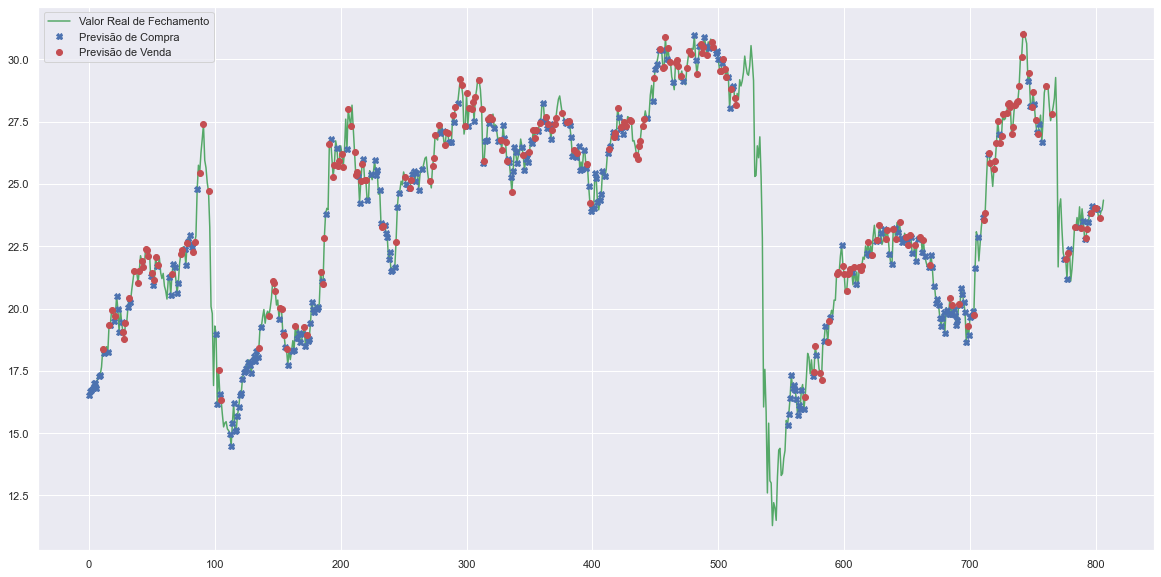

In [145]:
# Recomendações
trader_base.investir()

### 4.1. Execução do AI Bot Trader - Modelo Otimizado

In [146]:
melhor_trader(window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              population_size = int(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])), 
              sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              size_network = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))

Tempo Total de Treinamento: 34.225799560546875 segundos


6.383200454711914

In [147]:
modelo_otim = Modelo(input_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     layer_size = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     output_size = 3)

In [148]:
# Cria o trader com otimização
trader_otim = Trader(population_size = int(np.around(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     model = modelo_otim, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))


In [149]:
trader_otim.fit(500, 100)

Iteração 100. Recompensa: 5.563200
Iteração 200. Recompensa: 7.079200
Iteração 300. Recompensa: 7.223600
Iteração 400. Recompensa: 7.452300
Iteração 500. Recompensa: 7.461900
Tempo Total de Treinamento: 177.96184134483337 segundos


Dia 0: comprar 5 unidades ao preço de 82.749996, saldo total 9917.250004
Dia 15: comprar 5 unidades ao preço de 91.199999, saldo total 9826.050005
Dia 30: comprar 5 unidades ao preço de 97.100000, saldo total 9728.950005
Dia 45: comprar 5 unidades ao preço de 111.949997, saldo total 9617.000008
Dia 60: comprar 5 unidades ao preço de 104.499998, saldo total 9512.500010
Dia 75: comprar 5 unidades ao preço de 112.399998, saldo total 9400.100012
Dia 90, vender 5 unidades ao preço de 133.950005, investimento 61.873125 %, saldo total 9534.050016,
Dia 105: comprar 5 unidades ao preço de 81.650000, saldo total 9452.400017
Dia 120: comprar 5 unidades ao preço de 82.749996, saldo total 9369.650021
Dia 135: comprar 5 unidades ao preço de 91.999998, saldo total 9277.650023
Dia 150: comprar 5 unidades ao preço de 101.700001, saldo total 9175.950022
Dia 165: comprar 5 unidades ao preço de 93.999996, saldo total 9081.950026
Dia 180: comprar 5 unidades ao preço de 100.699997, saldo total 8981.250029
D

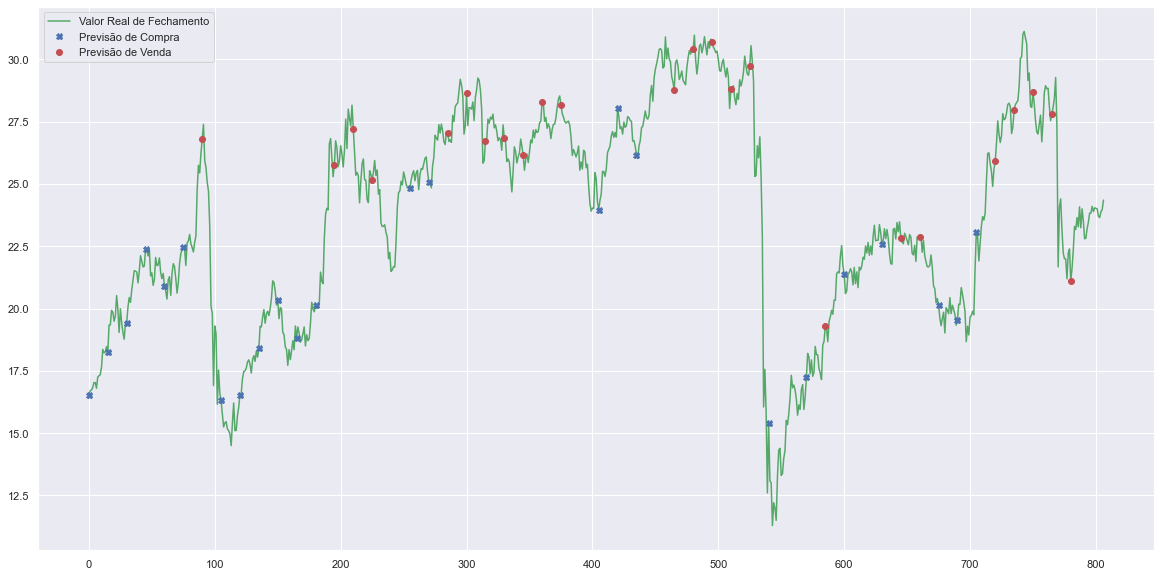

In [150]:
trader_otim.investir()

## 5. Conclusão, Lições Aprendidas e Próximos Passos

- Um projeto como esse é complexo e requer conhecimento avançado.
- Nosso Trader demonstrou bons resultados com baixo volume de dados. Teríamos que validar isso com volumes de dados maiores.
- Diferentes políticas podem ser usadas para treinar o Trader e essa é uma decisão humana.
- Diferentes arquiteturas podem ser usadas no modelo e essa é uma decisão humana.
- Todas as técnicas usadas neste projeto podem ser refinadas com procedimentos mais avançados, tornando o AI Bot Trader ainda mais preciso.

## Fonte de Conteúdo:

<p style="text-align: left;">Site: <a href="http://www.rodolfoterra.com">Rodolfo Terra | Ciência de dados</a></p>

<p style="text-align: left;">Blog: <a href="https://rodolffoterra.github.io/">Aprenda Gratuitamente Linguagem R & Python</a></p>


<p style="text-align: left;">Github: <a href="https://github.com/rodolffoterra">rodolffoterra</a></p>

<p><img style="float: right;" src="imagens/logo.png" alt="RNA" /></p><br><br><br><br><br>